In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
import numpy as np
from kaggle_datasets import KaggleDatasets
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-16 02:32:47.976913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 02:32:47.977051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 02:32:48.153949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()
print(f'GCS_PATH: {GCS_PATH}')
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo JPG Files:', len(PHOTO_FILENAMES))

# Function to load and preprocess images
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    return image

# Create TensorFlow datasets
monet_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/monet_jpg/*.jpg')).map(load).take(100)
photo_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/photo_jpg/*.jpg')).map(load).take(250)



GCS_PATH: gs://kds-2bac02b6442f28e163ec4b67d2b23cb1b494b84653d5e7d71f1a55c8
Monet JPG Files: 300
Photo JPG Files: 7038


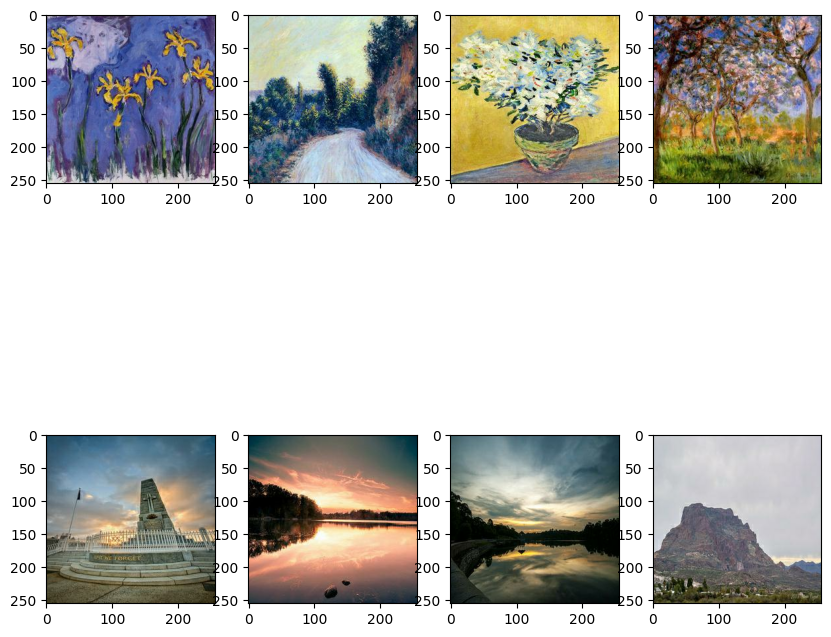

In [3]:
plt.figure(figsize=(10,10))

for i, img in enumerate(monet_ds.take(4)):
  plt.subplot(2,4,i+1)
  plt.imshow(img)

for i, img in enumerate(photo_ds.take(4)):
  plt.subplot(2,4,i+5)
  plt.imshow(img)

plt.show()

In [4]:
PHOTO_DATASET_SIZE = len(photo_ds)

train_size = int(0.8 * PHOTO_DATASET_SIZE)
test_size = int(0.2 * PHOTO_DATASET_SIZE)
BUFFER_SIZE = 1000

photo_ds = photo_ds.shuffle(BUFFER_SIZE)

train_photo_ds = photo_ds.take(train_size)
print('train_photo_ds:', len(train_photo_ds))
test_photo_ds = photo_ds.skip(train_size)
test_photo_ds = photo_ds.take(test_size)


# Monet
MONET_DATASET_SIZE = len(monet_ds)
BUFFER_SIZE = 1000

monet_ds = monet_ds.shuffle(BUFFER_SIZE)

train_monet_ds = monet_ds

train_photo_ds: 200


## Resize and Preprocess Image

In [5]:
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 3


def resize(image):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  return image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def denormalize(image):
  image = tf.cast(image, tf.float32)
  image = (image * 0.5 + 0.5) * 255 # Range 0 to 1 and then to range 0..255
  image = tf.cast(image, tf.int32)
  return image

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

def random_jitter(image):
  # resizing to 350 x 350 x 3
  image = tf.image.resize(image, [350, 350],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = resize(image)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = resize(image)
  image = normalize(image)
  return image

In [6]:
train_photo_ds = train_photo_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo_ds = test_photo_ds.map(
    preprocess_image_test).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_monet_ds = train_monet_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

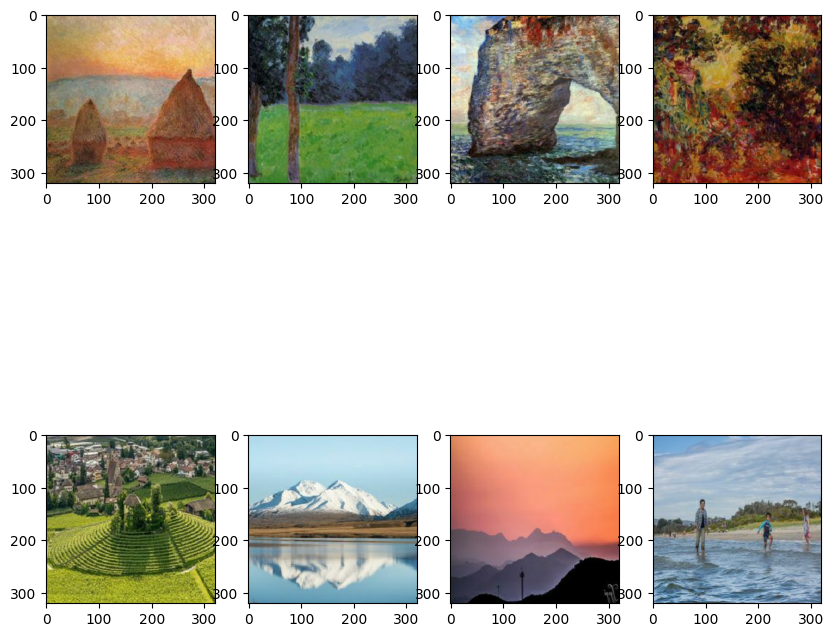

In [7]:
plt.figure(figsize=(10,10))

for i, img in enumerate(train_monet_ds.take(4)):
  plt.subplot(2,4,i+1)
  plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

for i, img in enumerate(train_photo_ds.take(4)):
  plt.subplot(2,4,i+5)
  plt.imshow(denormalize(img[0,...]), vmin=0, vmax=255) # first dimension (batch) is eliminated and we denormalize the image

plt.show()

## Generator

In [8]:
def downsample(filters, kernel_size=4, strides=2, apply_norm=True):
  result = keras.Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # Convolutional layer
  result.add(layers.Conv2D(filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_norm)) # when applying Normalization you already have the bias implicit

  # Normalization layer

  # Activation layer
  result.add(layers.LeakyReLU())

  return result

In [9]:
def upsample(filters, kernel_size=4, strides=2, apply_dropout=True):
  result = keras.Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # Transpose convolutional layer
  result.add(layers.Conv2DTranspose(filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding="same",
                            kernel_initializer=initializer,
                            use_bias=False)) # when applying BatchNormalization already has implicit bias

  # Normalization layer

  # Dropout layer
  if apply_dropout:
    result.add(layers.Dropout(0.5))

  # Activation layer
  result.add(layers.ReLU())

  return result

In [10]:
def Generator():

  inputs = layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])

  down_stack = [
                downsample(64, apply_norm=False),
                downsample(128),
                downsample(256),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512, kernel_size=5, strides=5),
  ]

  up_stack = [
                upsample(512, kernel_size=5, strides=5),
                upsample(512),
                upsample(512, apply_dropout=False),
                upsample(256, apply_dropout=False),
                upsample(128, apply_dropout=False),
                upsample(64, apply_dropout=False),
  ]

  # Output layer
  initializer = tf.random_normal_initializer(0,0.02)
  last = layers.Conv2DTranspose(filters = 3, # Number of image channels
                                kernel_size=4,
                                strides=2,
                                padding="same",
                                kernel_initializer=initializer,
                                activation="tanh" # output -1 to 1
                                )

  x = inputs
  skips = []

  # We add the Encoder blocks to the model and save the outputs to later perform the Skip Connections
  for down in down_stack:
    x = down(x)
    skips.append(x)


  # We eliminate the last layer of the Skips Connections,
  # since it will be a direct input in the first block of the Decoder
  # and we turn the Skips around since the second layer must connect
  # with the penultimate output of the Encoder, the third with the penultimate .
  # and so on successively
  skips = reversed(skips[:-1])

  # We add the Decoder blocks to the model and sthe Skip Connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x,skip])
  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)

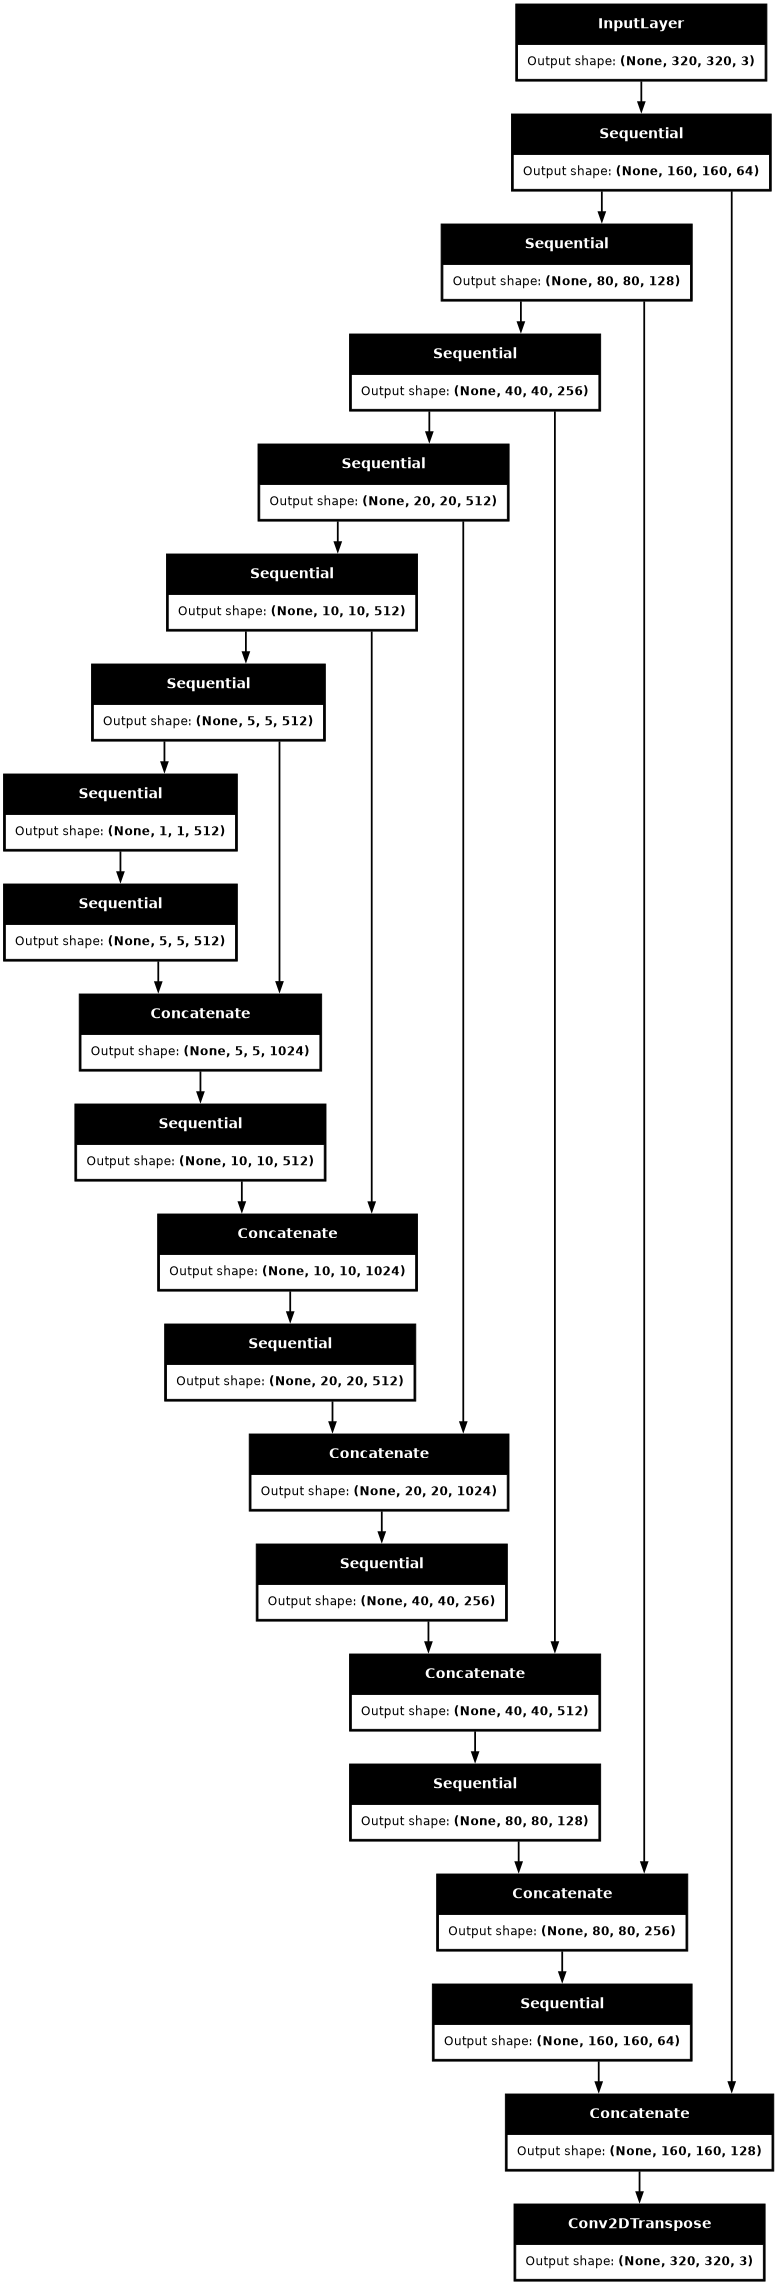

In [11]:
generator_g = Generator()
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

## Discriminator

In [12]:
def Discriminator():

  ini = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name="input_img")

  down1 = downsample(64, apply_norm=False)(ini)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)

  initializer = tf.random_normal_initializer(0., 0.02)
  conv = tf.keras.layers.Conv2D(512,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)

  gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  leaky_relu = tf.keras.layers.LeakyReLU()(conv)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer)(zero_pad2)

  return keras.Model(inputs=ini, outputs=last)

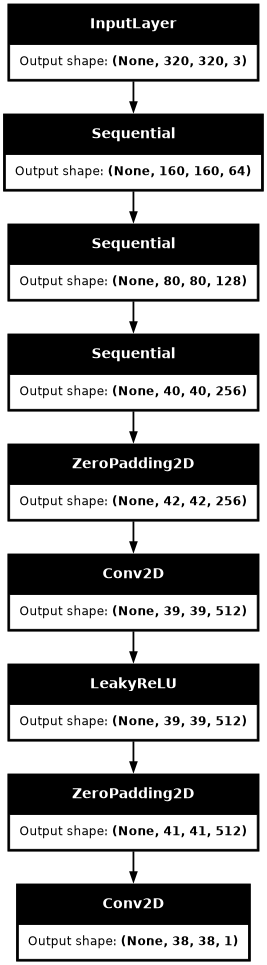

In [13]:
discriminator_y = Discriminator()
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

## Build the Model

In [14]:
generator_monet = Generator()
generator_photo = Generator()

discriminator_monet = Discriminator()
discriminator_photo = Discriminator()
  

In [15]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
print(f'loss_object: {loss_object}')

loss_object: <keras.src.losses.losses.BinaryCrossentropy object at 0x79da2abdd9f0>


In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
    #compare the real image with a matrix of 1. (All Ok)
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    #compare the fake image with a matrix of 0 (All Fake)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = (real_loss + generated_loss) / 2

    return total_disc_loss

In [17]:
def generator_adversarial_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

In [18]:
def generator_calc_cycle_loss(real_image, cycled_image, param_lambda):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    print(f'loss1: {loss1}')
    return param_lambda * loss1

In [19]:
def generator_identity_loss(real_image, same_image, param_lambda):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    print(f'loss: {loss}')
    return param_lambda * 0.5 * loss

In [20]:
generator_monet_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
generator_photo_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

discriminator_monet_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [21]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_monet,
        generator_photo,
        discriminator_monet,
        discriminator_photo,
        lambda_cycle=10,
        lambda_identity=10
    ):
        super(CycleGan, self).__init__()
        self.generator_monet = generator_monet
        self.generator_photo = generator_photo
        self.discriminator_monet = discriminator_monet
        self.discriminator_photo = discriminator_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity


    def compile(
        self,
        generator_monet_optimizer,
        generator_photo_optimizer,
        discriminator_monet_optimizer,
        discriminator_photo_optimizer,
        discriminator_loss,
        generator_adversarial_loss,
        generator_calc_cycle_loss,
        generator_identity_loss
    ):
        super(CycleGan, self).compile()
        self.generator_monet_optimizer = generator_monet_optimizer
        self.generator_photo_optimizer = generator_photo_optimizer
        self.discriminator_monet_optimizer = discriminator_monet_optimizer
        self.discriminator_photo_optimizer = discriminator_photo_optimizer
        self.discriminator_loss = discriminator_loss
        self.generator_adversarial_loss = generator_adversarial_loss
        self.generator_calc_cycle_loss = generator_calc_cycle_loss
        self.generator_identity_loss = generator_identity_loss



    def train_step(self, batch_data):

        monet, photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Get Predictions
            # from photo we generate Monet (fake) and regenerate the photo again (cycle)
            gen_output_monet_fake = self.generator_monet(photo, training=False)
            gen_output_photo_cycle = self.generator_photo(gen_output_monet_fake, training=False)

            # from Monet we generate photo (fake) and regenerate Monet again (cycle)
            gen_output_photo_fake = self.generator_photo(monet, training=False)
            gen_output_monet_cycle = self.generator_monet(gen_output_photo_fake, training=False)

            # generating itself are used for identity loss.
            gen_output_monet_same = self.generator_monet(monet, training=False)
            gen_output_photo_same = self.generator_photo(photo, training=False)


            # Run the discriminator for real Monet (input) and generated Monet (fake)
            disc_out_monet_real = self.discriminator_monet(monet, training=False)
            disc_out_monet_fake = self.discriminator_monet(gen_output_monet_fake, training=False)

            # Run the discriminator for Real Photo (input) and Photo (fake)
            disc_out_photo_real = self.discriminator_photo(photo, training=False)
            disc_out_photo_fake = self.discriminator_photo(gen_output_photo_fake, training=False)

            # Calculate the loss
            gen_monet_adversarial_loss = self.generator_adversarial_loss(disc_out_monet_fake)
            gen_photo_adversarial_loss = self.generator_adversarial_loss(disc_out_photo_fake)

            # evaluates total cycle consistency loss
            total_cycle_loss = (self.generator_calc_cycle_loss(monet, gen_output_monet_cycle, self.lambda_cycle)
                                + self.generator_calc_cycle_loss(photo, gen_output_photo_cycle, self.lambda_cycle))

            gen_monet_identity_loss = self.generator_identity_loss(monet, gen_output_monet_same, self.lambda_identity)
            gen_photo_identity_loss = self.generator_identity_loss(photo, gen_output_photo_same, self.lambda_identity)

            # Total generator loss = adversarial loss + cycle loss + identity loss
            total_gen_monet_loss = (gen_monet_adversarial_loss + total_cycle_loss + gen_monet_identity_loss)
            total_gen_photo_loss = (gen_photo_adversarial_loss + total_cycle_loss + gen_photo_identity_loss)


            disc_monet_loss = self.discriminator_loss(disc_out_monet_real, disc_out_monet_fake)
            disc_photo_loss = self.discriminator_loss(disc_out_photo_real, disc_out_photo_fake)


        # Calculate the gradients for generator and discriminator
        gen_monet_gradients = tape.gradient(total_gen_monet_loss,
                                            self.generator_monet.trainable_variables)
        gen_photo_gradients = tape.gradient(total_gen_photo_loss,
                                            self.generator_photo.trainable_variables)


        disc_monet_gradients = tape.gradient(disc_monet_loss,
                                                self.discriminator_monet.trainable_variables)
        disc_photo_gradients = tape.gradient(disc_photo_loss,
                                               self.discriminator_photo.trainable_variables)

        # Apply the gradients to the optimizer


        self.generator_monet_optimizer.apply_gradients(zip(gen_monet_gradients,
                                                      self.generator_monet.trainable_variables))
        self.generator_photo_optimizer.apply_gradients(zip(gen_photo_gradients,
                                                     self.generator_photo.trainable_variables))

        self.discriminator_monet_optimizer.apply_gradients(zip(disc_monet_gradients,
                                                         self.discriminator_monet.trainable_variables))
        self.discriminator_photo_optimizer.apply_gradients(zip(disc_photo_gradients,
                                                        self.discriminator_photo.trainable_variables))

        return {
            "total_gen_monet_loss": total_gen_monet_loss,
            "total_gen_photo_loss": total_gen_photo_loss,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss
        }

In [22]:
cycle_gan_model = CycleGan(
      generator_monet, generator_photo, discriminator_monet, discriminator_photo
  )

cycle_gan_model.compile(
      generator_monet_optimizer = generator_monet_optimizer,
      generator_photo_optimizer = generator_photo_optimizer,
      discriminator_monet_optimizer = discriminator_monet_optimizer,
      discriminator_photo_optimizer = discriminator_photo_optimizer,
      discriminator_loss = discriminator_loss,
      generator_adversarial_loss = generator_adversarial_loss,
      generator_calc_cycle_loss = generator_calc_cycle_loss,
      generator_identity_loss = generator_identity_loss
  )

In [23]:
import time

t1 = time.process_time()

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_photo_ds, train_monet_ds)),
    epochs=1,
)

t2 = time.process_time()

print ("Accelerator =  ----- Computation time = " + str(1000*(t2 - t1)) + "ms")

loss1: Tensor("Mean:0", shape=(), dtype=float32)
loss1: Tensor("Mean_1:0", shape=(), dtype=float32)
loss: Tensor("Mean_2:0", shape=(), dtype=float32)
loss: Tensor("Mean_3:0", shape=(), dtype=float32)
loss1: Tensor("Mean:0", shape=(), dtype=float32)
loss1: Tensor("Mean_1:0", shape=(), dtype=float32)
loss: Tensor("Mean_2:0", shape=(), dtype=float32)
loss: Tensor("Mean_3:0", shape=(), dtype=float32)
34/34 ━━━━━━━━━━━━━━━━━━━━ 598s 17s/step - disc_monet_loss: 0.8778 - disc_photo_loss: 0.7937 - total_gen_monet_loss: 7.4624 - total_gen_photo_loss: 7.5040 - loss: 0.0000e+00
Accelerator =  ----- Computation time = 2283443.6126399995ms


In [24]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  plt.subplot(1, 2, 1)
  plt.imshow(test_input[0] * 0.5 + 0.5)
  plt.title('Input Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(prediction[0] * 0.5 + 0.5)
  plt.title('Predicted Image')
  plt.axis('off')

  plt.show()

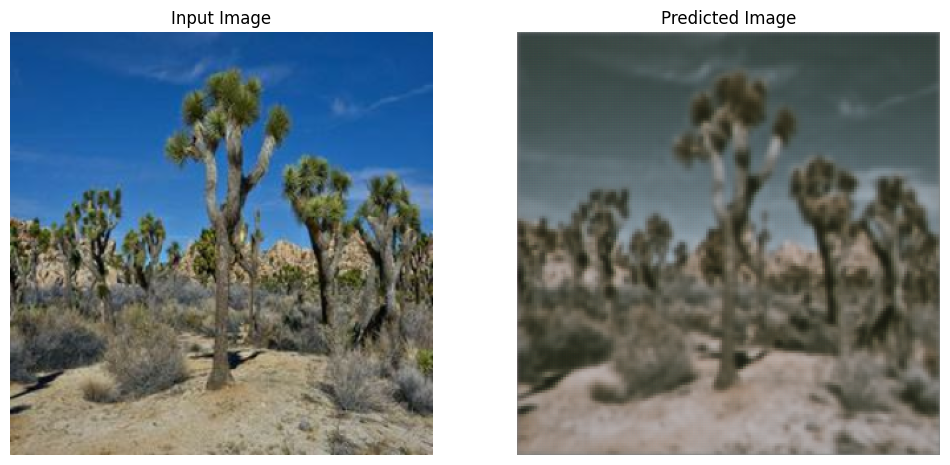

In [25]:
image = next(iter(test_photo_ds))

# Ensure the image is of shape (320, 320, 3) and add a batch dimension
# Now 'image_batch' has the correct shape for the model
generate_images(generator_monet, image)

In [26]:
i = 1
photo_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/photo_jpg/*.jpg')).map(load).take(7038)
pre_processed_photo_ds = photo_ds.map(
    preprocess_image_train).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

for img in pre_processed_photo_ds:
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #im = PIL.Image.fromarray(prediction)
    im = Image.fromarray(prediction)
    os.makedirs("../images/", exist_ok=True)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'